In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import os
os.chdir('../methods')
import lsci, supr, conf, uqno
os.chdir('../gpsims')

In [3]:
def risk(lower, upper, residual):
    return jnp.mean((residual > lower)*(residual < upper))

In [4]:
def split_data(data, lag, horizon):
    horizon = horizon-1
    y_t = data[(lag + horizon):][:,None]
    x_t = np.stack([data[(lag-i-1):(-(i+1+horizon))] for i in range(lag)], axis = 1)
    return x_t.copy(), y_t.copy()

def torch2jax(x):
    return jnp.array(x.numpy())

In [5]:
class ANO_layer(nnx.Module):
    def __init__(self, width, rngs: nnx.Rngs):
        self.linear = nnx.Linear(width, width, rngs=rngs)
        # self.bn = nnx.BatchNorm(dmid, rngs=rngs)
        # self.dropout = nnx.Dropout(0.2, rngs=rngs)
        self.linear_out = nnx.Linear(width, width, rngs=rngs)
        
    def __call__(self, x):
        # channel mix
        h = self.linear(x)

        # spatial mix
        g = jnp.mean(x, axis = (1, 2))[:,None,None,:]

        # sum
        x = h + g
        x = nnx.relu(x)

        return self.linear_out(x)

class encode_layer(nnx.Module):
    def __init__(self, in_dim, out_dim, rngs):
        self.linear = nnx.Linear(in_dim, out_dim, rngs=rngs)

    def __call__(self, x):
        return self.linear(x)

class DeepANO(nnx.Module):
    def __init__(self, in_dim, width, out_dim, rngs):
        self.encode_layer = encode_layer(in_dim, width, rngs)
        self.ano1 = ANO_layer(width, rngs)
        self.ano2 = ANO_layer(width, rngs)
        self.ano3 = ANO_layer(width, rngs)
        self.decode_layer = encode_layer(width, out_dim, rngs)

    def __call__(self, x):
        x = self.encode_layer(x)
        x = self.ano1(x)
        x = self.ano2(x)
        x = self.ano3(x)
        x = self.decode_layer(x)
        return x

In [6]:
class ProbANO(nnx.Module):
    def __init__(self, in_dim, width, out_dim, rngs):
        self.mu_ano = DeepANO(in_dim, width, out_dim, rngs)
        self.sd_ano = DeepANO(in_dim, width, out_dim, rngs)

    def __call__(self, x):
        mu = self.mu_ano(x)
        log_sd = self.sd_ano(x)
        return mu, jnp.exp(log_sd)

In [7]:
class DropANO(nnx.Module):
    def __init__(self, in_dim, width, out_dim, rngs):
        self.encode_layer = encode_layer(in_dim, width, rngs)
        self.ano1 = ANO_layer(width, rngs)
        self.ano2 = ANO_layer(width, rngs)
        self.ano3 = ANO_layer(width, rngs)
        self.decode_layer = encode_layer(width, out_dim, rngs)
        self.dropout = nnx.Dropout(0.1, rngs=rngs)

    def __call__(self, x):
        x = self.encode_layer(x)
        x = self.ano1(x)
        x = self.dropout(x)
        x = self.ano2(x)
        x = self.dropout(x)
        x = self.ano3(x)
        x = self.decode_layer(x)
        return x

In [8]:
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        y_pred = model(x)
        return jnp.mean((y_pred - y) ** 2)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # In place updates.

    return loss

def quant_step(model, optimizer, x, y):
    def loss_fn(model):
        quant = 1 - 0.1
        y_pred = model(x)
        y_abs = jnp.abs(y)
        resid = y_abs - y_pred
        loss = jnp.max(jnp.concat([quant * resid, -(1-quant) * resid], axis = 3), axis = 3)
        return jnp.mean(loss)
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # in-place updates

    return loss

def prob_step(model, optimizer, x, y):
    def loss_fn(model):
        mu, sd = model(x)
        var = sd**2
        nll = jnp.mean((mu - y)**2 / (2*var) + 0.5 * jnp.log(var))
        return nll

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # In place updates.

    return loss

train_step = nnx.jit(train_step)
quant_step = nnx.jit(quant_step)
prob_step = nnx.jit(prob_step)

In [ ]:
def gp1d(n, p):
    pass
    

In [357]:
def conv(x, k):
    return jnp.convolve(x, k, mode = 'valid')
conv = jit(vmap(conv, (0, None)))
kernel = jnp.ones(5)/5

rng0 = 100
key1 = random.PRNGKey(rng0 + 1)
key2 = random.PRNGKey(rng0 + 2)
key3 = random.PRNGKey(rng0 + 3)

t = jnp.linspace(0, 1, 108)
s = jnp.linspace(-2*math.pi, 2*math.pi, 501)

amp = jnp.sin(s)
sd = jnp.sin(s)

f = jnp.sin(2 * math.pi * t)
f = 10 + amp[:,None] * f[None,:]

xtrain = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key1, f.shape)
xtrain = conv(conv(xtrain.squeeze(), kernel), kernel)
xtrain, ytrain = split_data(xtrain, 1, 1)
xtrain = xtrain[:,:,:,None]
ytrain = ytrain[:,:,:,None]

xval = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key2, f.shape)
xval = conv(conv(xval.squeeze(), kernel), kernel)

xval, yval = split_data(xval, 1, 1)
xval = xval[:,:,:,None]
yval = yval[:,:,:,None]

xtest = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key3, f.shape)
xtest = conv(conv(xtest.squeeze(), kernel), kernel)

xtest, ytest = split_data(xtest, 1, 1)
xtest = xtest[:,:,:,None]
ytest = ytest[:,:,:,None]

sigma = 0.25 * (1.15 + sd)

In [358]:
# def conv(x, k):
#     return jnp.convolve(x, k, mode = 'same')
# conv = jit(vmap(conv, (0, None)))
# kernel = jnp.ones(5)/5

# ### train
# rng0 = 1
# key1 = random.PRNGKey(rng0 + 1)

# n, p = 1000, 50
# beta = random.normal(key1, (5,))
# bias = 1

# rng0 = 2
# rng = random.PRNGKey(rng0)
# key1, key2, key3 = random.split(rng, 3)

# xtrain = conv(conv(random.normal(key1, (n, p)), kernel), kernel)
# sigma = jnp.std(xtrain, axis = 1)
# sigma = sigma - jnp.mean(sigma) + 1
# epsilon = sigma[:,None] * conv(conv(random.normal(key2, (n, p)), kernel), kernel)

# ytrain = bias + conv(xtrain, beta) + epsilon
# xtrain = xtrain[:,None,:,None]
# ytrain = ytrain[:,None,:,None]

# ### valid
# rng0 += 1
# rng = random.PRNGKey(rng0)
# key1, key2, key3 = random.split(rng, 3)

# xval = conv(conv(random.normal(key1, (n, p)), kernel), kernel)
# sigma = jnp.std(xval, axis = 1)
# sigma = sigma - jnp.mean(sigma) + 1
# epsilon = sigma[:,None] * conv(conv(random.normal(key2, (n, p)), kernel), kernel)

# yval = bias + conv(xval, beta) + epsilon
# xval = xval[:,None,:,None]
# yval = yval[:,None,:,None]


# ### test
# rng0 += 1
# rng = random.PRNGKey(rng0)
# key1, key2, key3 = random.split(rng, 3)

# xtest = conv(conv(random.normal(key1, (n, p)), kernel), kernel)
# sigma = jnp.std(xtest, axis = 1)
# sigma = sigma - jnp.mean(sigma) + 1
# epsilon = sigma[:,None] * conv(conv(random.normal(key2, (n, p)), kernel), kernel)

# ytest = bias + conv(xtest, beta) + epsilon
# xtest = xtest[:,None,:,None]
# ytest = ytest[:,None,:,None]

In [359]:
train_data = TensorDataset(torch.Tensor(xtrain), torch.Tensor(ytrain))
train_loader = DataLoader(train_data, batch_size = 30, shuffle = True)

In [360]:
epochs = 100
trace = []
lag, lead = 1, 1

base_model = DeepANO(lag, 50, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(base_model, optax.adam(1e-3))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = train_step(base_model, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/100 [00:00<?, ?it/s]

In [361]:
drop_model = DropANO(lag, 50, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(drop_model, optax.adam(1e-3))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = train_step(drop_model, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/100 [00:00<?, ?it/s]

In [362]:
quant_model = DeepANO(lag, 50, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(quant_model, optax.adam(1e-3))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = quant_step(quant_model, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/100 [00:00<?, ?it/s]

In [363]:
prob_model = ProbANO(lag, 50, lead, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(prob_model, optax.adam(1e-4))
rng = random.PRNGKey(0)

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        loss = prob_step(prob_model, optim, xt, yt)
        trace.append(loss)

  0%|          | 0/100 [00:00<?, ?it/s]

In [364]:
yval_hat = base_model(xval)
ytest_hat = base_model(xtest)

yval_quant = quant_model(xval)
ytest_quant = quant_model(xtest)

yval_mu, yval_sd = prob_model(xval)
ytest_mu, ytest_sd = prob_model(xtest)

In [365]:
yval = yval.squeeze()
ytest = ytest.squeeze()

yval_hat = yval_hat.squeeze()
ytest_hat = ytest_hat.squeeze()
yval_quant = yval_quant.squeeze()
ytest_quant = ytest_quant.squeeze()
yval_mu = yval_mu.squeeze()
yval_sd = yval_sd.squeeze()
ytest_mu = ytest_mu.squeeze()
ytest_sd = ytest_sd.squeeze()

In [366]:
# yval = yval.reshape(yval.shape[0], -1)
# mu_val = yval_hat.reshape(mu_val.shape[0], -1)
# sd_val = sd_val.reshape(sd_val.shape[0], -1)

In [367]:
def pdon(prob_model, xval, xtest, yval, alpha):
    
    nval = xval.shape[0]
    ntest = xtest.shape[0]
    
    mu_val, sd_val = prob_model(xval)
    mu_test, sd_test = prob_model(xtest)
    
    yval = yval.reshape(nval, -1)
    mu_val = mu_val.reshape(nval, -1)
    sd_val = sd_val.reshape(nval, -1)
    mu_test = mu_test.reshape(ntest, -1)
    sd_test = sd_test.reshape(ntest, -1)
    
    alpha_adj = jnp.ceil((1-alpha) * (nval + 1))/(nval)
    
    score = jnp.abs(yval - mu_val)/sd_val
    q = jnp.quantile(score, alpha_adj, axis = 0)
    
    lower = -sd_test * q[None,]
    upper = sd_test * q[None,]
    return lower, upper

In [368]:
def qdon(quant_model, xval, xtest, yval, alpha):
    
    nval = xval.shape[0]
    ntest = xtest.shape[0]
    
    yval = yval.reshape(nval, -1)
    
    quant_val = quant_model(xval).reshape(nval, -1)
    quant_test = quant_model(xtest).reshape(nval, -1)
    
    alpha_adj = jnp.ceil((1-alpha) * (nval + 1))/(nval)
    
    lower = -quant_val - yval
    upper = yval - quant_val
    score = jnp.max(jnp.stack([lower, upper], axis = 2), axis=2)
    q = jnp.quantile(score, alpha_adj, axis = 0)
    
    lower = -quant_test - q[None,]
    upper = quant_test + q[None,]
    return lower, upper

In [369]:
# pdon_lower, pdon_upper = pdon(prob_model, xval, xtest, yval, alpha)

In [370]:
def gaussian_score(res, mu, sd):
    nll = jnp.mean((mu - res)**2 / (2*sd**2) + 0.5 * jnp.log(sd**2))
    return jnp.exp(-nll)
gaussian_score = vmap(gaussian_score, (0, None, None))

def gaus_band(residuals, pca_state, alpha):
    res_proj = pcax.transform(pca_state, residuals)
    mu = jnp.mean(res_proj, axis = 0)
    sd = jnp.std(res_proj, axis = 0)
    dval_conf = gaussian_score(res_proj, mu, sd)
    qval_conf = jnp.quantile(dval_conf, alpha)
    conf_ens = pcax.recover(pca_state, res_proj[dval_conf > qval_conf])
    conf_lower = jnp.min(conf_ens, axis = 0)
    conf_upper = jnp.max(conf_ens, axis = 0)
    return conf_lower, conf_upper

In [371]:
# plt.plot(pdon_lower[2])
# plt.plot(pdon_upper[2])
# plt.plot(rtest2[2])

In [372]:
# nproj = 90
# gamma1 = 0.2
# alpha = 0.1
# nval = xval.shape[0]
# alpha1 = 1 - jnp.ceil((1-alpha) * (gamma1*nval + 1))/(gamma1*nval)

In [373]:
# yval = yval.reshape(yval.shape[0], -1)
# yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
# # pca_state = lsci.phi_state(yval, yval_hat, nproj)

In [374]:
# UQNO lambda estimate
# yval_quant = yval_quant.reshape(yval_quant.shape[0], -1)
# ytest_quant = ytest_quant.reshape(ytest_quant.shape[0], -1)

alpha = 0.1
delta = 0.1
# m = 32*64
m = 100
tau = 1.1 * jnp.sqrt(-jnp.log(delta)/(2*m))
sg = jnp.abs(yval - yval_hat) / yval_quant
sg = jnp.quantile(sg, 1-alpha+tau, axis = (1))
nval = sg.shape[0]

adj_alpha = 1 - jnp.ceil((nval + 1) * (delta - jnp.exp(-2*m*tau**2)))/nval
lam_uqno = jnp.quantile(sg, adj_alpha)
lam_uqno

Array(0.07459346, dtype=float32)

In [ ]:
nproj = 100
gamma1 = 0.1
gamma2 = 0.05
alpha = 0.1
nval = xval.shape[0]
alpha1 = 1 - jnp.ceil((1-alpha) * (gamma1*nval + 1))/(gamma1*nval)
alpha2 = 1 - jnp.ceil((1-alpha) * (gamma2*nval + 1))/(gamma2*nval)

drop_risk = []
orcl_risk = []
conf_risk = []
gaus_risk = []
supr_risk = []
uqn1_risk = []
pdon_risk = []
qdon_risk = []
lsc1_risk = []
lsc2_risk = []

drop_width = []
orcl_width = []
conf_width = []
gaus_width = []
supr_width = []
uqn1_width = []
pdon_width = []
qdon_width = []
lsc1_width = []
lsc2_width = []

pca_state = lsci.phi_state(yval, yval_hat, nproj)

rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()
rtest2 = (ytest - ytest_mu).squeeze()

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
gaus_lower, gaus_upper = gaus_band(rval, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval, alpha)
uqn1_lower, uqn1_upper = uqno.uqno_band(ytest_quant, lam_uqno)
pdon_lower, pdon_upper = pdon(prob_model, xval, xtest, yval, alpha)
qdon_lower, qdon_upper = qdon(quant_model, xval, xtest, yval - yval_hat, alpha)

for i in trange(0, ytest.shape[0]):
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci(rval, xval, xtest[i], pca_state, alpha1, gamma1, 2000)
    lsc1_risk.append(risk(lsc1_lower, lsc1_upper, rtest[i]))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))
    
    # LSCI
    lsc2_lower, lsc2_upper = lsci.lsci(rval, xval, xtest[i], pca_state, alpha2, gamma2, 2000)
    lsc2_risk.append(risk(lsc2_lower, lsc2_upper, rtest[i]))
    lsc2_width.append(jnp.median(lsc2_upper - lsc2_lower))

    # Oracle
    orcl_lower = -(jnp.abs(rtest[i]) + 1e-4)
    orcl_upper = jnp.abs(rtest[i]) + 1e-4
    orcl_risk.append(risk(orcl_lower, orcl_upper, rtest[i]))
    orcl_width.append(jnp.median(orcl_upper - orcl_lower))
    
    # CONF 
    conf_risk.append(risk(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.median(conf_upper - conf_lower))
    
    # GAUSS 
    gaus_risk.append(risk(gaus_lower, gaus_upper, rtest[i]))
    gaus_width.append(jnp.median(gaus_upper - gaus_lower))
    
    # SUPR
    supr_risk.append(risk(supr_lower, supr_upper, rtest[i]))
    supr_width.append(jnp.median(supr_upper - supr_lower))
    
    # UQNO
    uqn1_risk.append(risk(uqn1_lower[i], uqn1_upper[i], rtest[i]))
    uqn1_width.append(jnp.median(uqn1_upper[i] - uqn1_lower[i]))
    
    # PDON
    pdon_risk.append(risk(pdon_lower[i], pdon_upper[i], rtest2[i]))
    pdon_width.append(jnp.median(pdon_upper[i] - pdon_lower[i]))
    
    # PDON
    qdon_risk.append(risk(qdon_lower[i], qdon_upper[i], rtest[i]))
    qdon_width.append(jnp.median(qdon_upper[i] - qdon_lower[i]))
    
    # DROPOUT
    drop_model.train()
    drop_set = jnp.stack([drop_model(xtest[i:(i+1)]).squeeze() for _ in range(500)])
    drop_lower = jnp.quantile(drop_set, alpha/2, axis = 0)
    drop_upper = jnp.quantile(drop_set, 1 - alpha/2, axis = 0)
    drop_model.eval()
    
    drop_risk.append(risk(drop_lower, drop_upper, rtest[i]))
    drop_width.append(jnp.median(drop_upper - drop_lower))


orcl_risk = np.array(orcl_risk)
drop_risk = np.array(drop_risk)
conf_risk = np.array(conf_risk)
gaus_risk = np.array(gaus_risk)
supr_risk = np.array(supr_risk)
uqn1_risk = np.array(uqn1_risk)
lsc1_risk = np.array(lsc1_risk)
lsc2_risk = np.array(lsc2_risk)
pdon_risk = np.array(pdon_risk)
qdon_risk = np.array(qdon_risk)

orcl_width = np.array(orcl_width)
drop_width = np.array(drop_width)
conf_width = np.array(conf_width)
gaus_width = np.array(gaus_width)
supr_width = np.array(supr_width)
uqn1_width = np.array(uqn1_width)
lsc1_width = np.array(lsc1_width)
lsc2_width = np.array(lsc2_width)
pdon_width = np.array(pdon_width)
qdon_width = np.array(qdon_width)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
# lsc1_risk = random.normal(rng, (500,))
# lsc2_risk = random.normal(rng, (500,))
# lsc1_width = random.normal(rng, (500,))
# lsc2_width = random.normal(rng, (500,))

# drop_risk = random.normal(rng, (50,))
# drop_width = random.normal(rng, (50,))

In [ ]:
sigma.shape

In [ ]:
# noise_sd = np.std(rtest[0:100], axis = 1)
# noise_sd = 0.25 * (1.15 + sd)
# noise_sd = noise_sd[1:]
noise_sd = sigma[1:]
gamma = 0.99

risk_control = np.mean(orcl_risk >= gamma), \
               np.mean(drop_risk >= gamma), \
               np.mean(conf_risk >= gamma), \
               np.mean(gaus_risk >= gamma), \
               np.mean(supr_risk >= gamma), \
               np.mean(uqn1_risk >= gamma), \
               np.mean(pdon_risk >= gamma), \
               np.mean(qdon_risk >= gamma), \
               np.mean(lsc1_risk >= gamma), \
               np.mean(lsc2_risk >= gamma)

width = np.mean(orcl_width), \
        np.mean(drop_width), \
        np.mean(conf_width), \
        np.mean(gaus_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(pdon_width), \
        np.mean(qdon_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = -0, \
           np.corrcoef([noise_sd, drop_risk])[0,1], \
           np.corrcoef([noise_sd, conf_risk])[0,1], \
           np.corrcoef([noise_sd, gaus_risk])[0,1], \
           np.corrcoef([noise_sd, supr_risk])[0,1], \
           np.corrcoef([noise_sd, uqn1_risk])[0,1], \
           np.corrcoef([noise_sd, pdon_risk])[0,1], \
           np.corrcoef([noise_sd, qdon_risk])[0,1], \
           np.corrcoef([noise_sd, lsc1_risk])[0,1], \
           np.corrcoef([noise_sd, lsc2_risk])[0,1]

width_cor = 1, \
            np.corrcoef([noise_sd, drop_width])[0,1], \
            0, \
            0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, pdon_width])[0,1], \
            np.corrcoef([noise_sd, qdon_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [ ]:
np.set_printoptions(suppress=True)
print(np.round(metrics, 3))

In [398]:
# noise_sd = np.std(rtest[0:100], axis = 1)
noise_sd = 0.25 * (1.15 + sd)
noise_sd = noise_sd[1:]
gamma = 0.99

risk_control = np.mean(orcl_risk >= gamma), \
               np.mean(drop_risk >= gamma), \
               np.mean(conf_risk >= gamma), \
               np.mean(gaus_risk >= gamma), \
               np.mean(supr_risk >= gamma), \
               np.mean(uqn1_risk >= gamma), \
               np.mean(pdon_risk >= gamma), \
               np.mean(qdon_risk >= gamma), \
               np.mean(lsc1_risk >= gamma), \
               np.mean(lsc2_risk >= gamma)

width = np.mean(orcl_width), \
        np.mean(drop_width), \
        np.mean(conf_width), \
        np.mean(gaus_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(pdon_width), \
        np.mean(qdon_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = -0, \
           np.corrcoef([noise_sd, drop_risk])[0,1], \
           np.corrcoef([noise_sd, conf_risk])[0,1], \
           np.corrcoef([noise_sd, gaus_risk])[0,1], \
           np.corrcoef([noise_sd, supr_risk])[0,1], \
           np.corrcoef([noise_sd, uqn1_risk])[0,1], \
           np.corrcoef([noise_sd, pdon_risk])[0,1], \
           np.corrcoef([noise_sd, qdon_risk])[0,1], \
           np.corrcoef([noise_sd, lsc1_risk])[0,1], \
           np.corrcoef([noise_sd, lsc2_risk])[0,1]

width_cor = 1, \
            np.corrcoef([noise_sd, drop_width])[0,1], \
            0, \
            0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, pdon_width])[0,1], \
            np.corrcoef([noise_sd, qdon_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [399]:
np.set_printoptions(suppress=True)
print(np.round(metrics, 3))

[[ 1.     0.     0.21   1.   ]
 [ 0.       nan  0.796  0.102]
 [ 0.808 -0.476  1.294  0.   ]
 [ 0.812 -0.465  1.257  0.   ]
 [ 0.918 -0.316  1.481  0.   ]
 [ 0.964 -0.224  1.529 -0.024]
 [ 1.       nan 20.964 -0.126]
 [ 0.294 -0.108  1.019  0.446]
 [ 0.91   0.045  0.907  0.993]
 [ 0.886  0.068  0.876  0.993]]


In [400]:
for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        val = f'{np.round(np.nan_to_num(metrics[i,j]), 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

1.000 & 0.000 & 0.210 & 1.000 \\
0.000 & 0.000 & 0.796 & 0.102 \\
0.808 & -0.476 & 1.294 & 0.000 \\
0.812 & -0.465 & 1.257 & 0.000 \\
0.918 & -0.316 & 1.481 & 0.000 \\
0.964 & -0.224 & 1.529 & -0.024 \\
1.000 & 0.000 & 20.964 & -0.126 \\
0.294 & -0.108 & 1.019 & 0.446 \\
0.910 & 0.045 & 0.907 & 0.993 \\
0.886 & 0.068 & 0.876 & 0.993 \\


NameError: name 'n1' is not defined

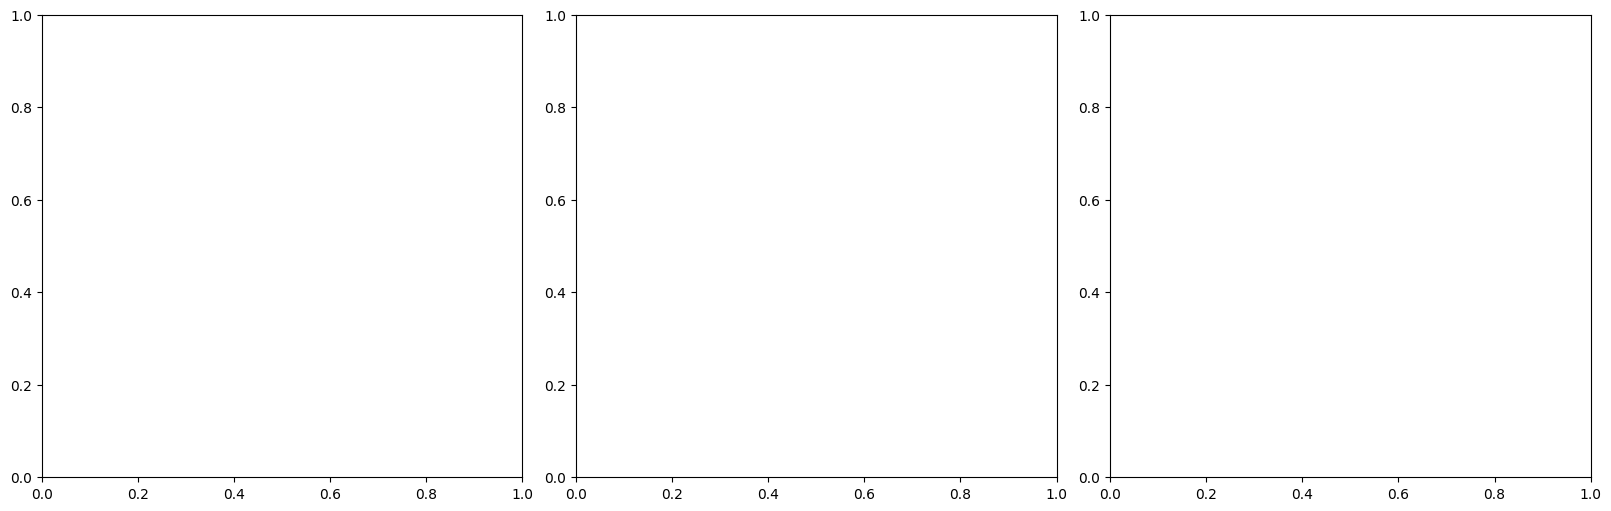

In [26]:
### examples
fig, ax = plt.subplots(1, 3, constrained_layout = True, figsize = (16, 5))

n = [0, 50, 200]
s = np.arange(92)
for i in range(3):

    lsc1_lower, lsc1_upper = lsci.lsci(rval, xval, xtest[n[i]], pca_state, alpha1, gamma1, 2000)
    uqno_lower, uqno_upper = uqn1_lower[n1], uqn1_upper[n[i]]

    ax[i].set_ylim(-1.5, 1.5)
    ax[i].plot(conf_upper.squeeze(), c = 'C0', lw = 0.5, label = 'Conf.')
    ax[i].plot(conf_lower.squeeze(), c = 'C0', lw = 0.5)
    ax[i].plot(supr_upper.squeeze(), c = 'C1', lw = 0.5, label = 'Supr.')
    ax[i].plot(supr_lower.squeeze(), c = 'C1', lw = 0.5)
    ax[i].plot(uqno_upper, c = 'C2', lw = 0.5, label = 'UQNO')
    ax[i].plot(uqno_lower, c = 'C2', lw = 0.5)
    ax[i].plot(lsc1_upper, c = 'C3', lw = 1.5, label = 'LSCI')
    ax[i].plot(lsc1_lower, c = 'C3', lw = 1.5)
    ax[i].plot(rtest[n[i]], c = 'black')
    
    ax[i].fill_between(s, conf_lower.squeeze(), conf_upper.squeeze(), alpha = 0.1)
    ax[i].fill_between(s, supr_lower.squeeze(), supr_upper.squeeze(), alpha = 0.1)
    ax[i].fill_between(s, uqno_lower.squeeze(), uqno_upper.squeeze(), alpha = 0.1)
    ax[i].fill_between(s, lsc1_lower.squeeze(), lsc1_upper.squeeze(), alpha = 0.1)
    
    ax[i].set_title(f't = {n[i]}', fontsize = 18)
ax[-1].legend(ncol = 4, fontsize = 12)

plt.show()

In [81]:
# plt.imshow(vp[0])
# plt.colorbar()

In [82]:
# u = swe.random_initial_condition()

# fig, ax = plt.subplots(1, 3, constrained_layout = True, figsize = (15, 4))
# ax[0].imshow(swe.isht(swe.timestep(u, 0))[0])
# ax[1].imshow(swe.isht(swe.timestep(u, 10))[0])
# ax[2].imshow(swe.isht(swe.timestep(u, 100))[0])

In [83]:
# plt.imshow(swe.isht(swe.timestep(u, 10))[0] - swe.isht(swe.timestep(u, 100))[0])
# plt.colorbar()

In [263]:
# z_score = 3.27
# oracle_sd = np.std(rtest, axis = 1)
oracle_rc = []
oracle_width = []
for i in trange(0, ytest.shape[0]):
    
    # Oracle    
    oracle_lower = jnp.min(rtest[i]) * jnp.ones((92,)) - 1e-7
    oracle_upper = jnp.max(rtest[i]) * jnp.ones((92,)) + 1e-7
    oracle_rc.append(risk(oracle_lower, oracle_upper, rtest[i]))
    oracle_width.append(jnp.mean(oracle_upper - oracle_lower))

oracle_rc = np.array(oracle_rc)
oracle_width = np.array(oracle_width)

  0%|          | 0/500 [00:00<?, ?it/s]

In [265]:
noise_sd = np.std(rtest, axis = 1)

risk_control = np.mean(oracle_rc >= 0.99), \
               np.mean(conf_rc >= 0.99), \
               np.mean(supr_rc >= 0.99), \
               np.mean(uqn1_rc >= 0.99), \
               np.mean(lsc1_rc >= 0.99), \
               np.mean(lsc2_rc >= 0.99)

width = np.mean(oracle_width), \
        np.mean(conf_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = 0, \
           np.corrcoef([noise_sd, conf_rc])[0,1], \
           np.corrcoef([noise_sd, supr_rc])[0,1], \
           np.corrcoef([noise_sd, uqn1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc2_rc])[0,1]

width_cor = np.corrcoef([noise_sd, oracle_width])[0,1], \
            0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [266]:
for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        val = f'{np.round(metrics[i,j], 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

1.000 & 0.000 & 0.613 & 0.984 \\
0.852 & -0.568 & 1.285 & 0.000 \\
0.888 & -0.505 & 1.422 & 0.000 \\
0.968 & -0.297 & 1.602 & 0.182 \\
0.924 & -0.013 & 0.912 & 0.928 \\
0.896 & -0.035 & 0.876 & 0.926 \\
